In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import numpy as np
%matplotlib inline

In [3]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [14]:
# build dataset
#size of the context
block_size = 8

def build_dataset(words):
	X, Y = [], []

	for w in words:
		context = [0] * block_size
		for ch in w + '.':
			ix = stoi[ch] # get integer value of char
			X.append(context) # add current context to X, the set of all contexts
			Y.append(ix) # add char after context to Y, the output based on corresponding context
			context = context[1:] + [ix] # drop the first thing in the context and add the last to the end
	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X, Y

#make training, validation, and test training sets
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [83]:
class Linear:
		def __init__(self, fan_in, fan_out, bias=True):
				# divide by sqr(fan_in) to get better distrubtion at start
				self.weight = torch.randn((fan_in, fan_out)) / fan_in**.5
				self.bias = torch.zeros(fan_out) if bias else None
		def __call__(self,x):
				self.out = x @ self.weight
				if self.bias is not None:
						self.out += self.bias
				return self.out
		def parameters(self):
				return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
	
	def __init__(self, dim, eps=1e-5, momentum=0.1):
		self.eps = eps
		self.momentum = momentum
		self.training = True
		# parameters (trained with backprop)
		self.gamma = torch.ones(dim)
		self.beta = torch.zeros(dim)
		# buffers (trained with a running 'momentum update')
		self.running_mean = torch.zeros(dim)
		self.running_var = torch.ones(dim)
	
	def __call__(self, x):
		# calculate the forward pass
		if self.training:
			if x.ndim == 2:
				dim = 0
			elif x.ndim == 3:
				dim = (0,1)
			xmean = x.mean(dim, keepdim=True) # batch mean
			xvar = x.var(dim, keepdim=True) # batch variance
		else:
			xmean = self.running_mean
			xvar = self.running_var
		xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
		self.out = self.gamma * xhat + self.beta
		# update the buffers
		if self.training:
			with torch.no_grad():
				self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
				self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
		return self.out
	
	def parameters(self):
		return [self.gamma, self.beta]

class Tanh:
		def __call__(self, x):
				self.out = torch.tanh(x)
				return self.out
		def parameters(self):
				return []

class Embedding:
	def __init__(self, num_embeddings, embedding_dim):
		self.weight = torch.randn((num_embeddings, embedding_dim))
	
	def __call__(self, IX):
		self.out = self.weight[IX]
		return self.out
	
	def parameters(self):
		return [self.weight]

# flattens some n consecutive elements in the last dimension	
class FlattenConsecutive:
	def __init__(self, n):
		"""
		n: num of consecutive elems to concatenate in the last dimension(2nd here(0,1,2 dims))
		"""
		self.n = n

	def __call__(self, x):
		B, T, C = x.shape
		#               use T//n instead of -1 bc -1 could cause errors ?? T//n is the expected value	
		x = x.view(B, T//self.n, C * self.n)
		if x.shape[1] == 1:
			# if 1st dimension is 1, squeeze it out and return 2d tensor
			x = x.squeeze(1)
		self.out = x
		return self.out

	def parameters(self):
		return []

class Sequential:
	def __init__(self, layers):
		self.layers = layers

	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		self.out = x
		return self.out
	
	# all parameters 
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]



In [84]:
torch.manual_seed(42)

In [ ]:
# Constructing the network

# i didnt use his ending params bc it would take longer than i want to wait to train
# the dimensionality of the character embedding vectors
n_embd = 10 # in video he ends with 24
# the number of neurons in the hidden layer of the MLP
n_hidden = 68 # in video he ends with 128

model = Sequential([
		Embedding(vocab_size, n_embd), 
		FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
		FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
		FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
		Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
		model.layers[-1].weight *= .1 # make last layer less confident
 
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
		p.requires_grad = True

22397


In [86]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)

In [87]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))
    

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [90]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
	# get batch index
	ix = torch.randint(0,Xtr.shape[0], (batch_size,))
	# get embeddings for x and y
	Xb, Yb = Xtr[ix], Ytr[ix]

	#forward pass
	logits = model(Xb)
	loss = F.cross_entropy(logits, Yb)
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	#update
	lr = .1 if i < 100000 else .01
	for p in parameters:
		p.data += -lr * p.grad

	# track stats
	if i % 10000 == 0:
		print(f"{i:7d}/{max_steps:7d}: {loss.item()}")
	lossi.append(loss.log10().item())
	#if i == 10000:b
		#break
	
	

      0/ 200000: 2.492016077041626
  10000/ 200000: 1.8997282981872559
  20000/ 200000: 2.0994479656219482
  30000/ 200000: 1.7295345067977905
  40000/ 200000: 1.990092158317566
  50000/ 200000: 2.187190532684326
  60000/ 200000: 1.645751714706421
  70000/ 200000: 1.9188963174819946
  80000/ 200000: 2.318789482116699
  90000/ 200000: 1.8850610256195068
 100000/ 200000: 1.894527554512024
 110000/ 200000: 2.1336498260498047
 120000/ 200000: 1.954216718673706
 130000/ 200000: 1.9434220790863037
 140000/ 200000: 1.9474472999572754
 150000/ 200000: 2.2559704780578613
 160000/ 200000: 1.7580848932266235
 170000/ 200000: 1.858842134475708
 180000/ 200000: 1.8711119890213013
 190000/ 200000: 1.8979116678237915


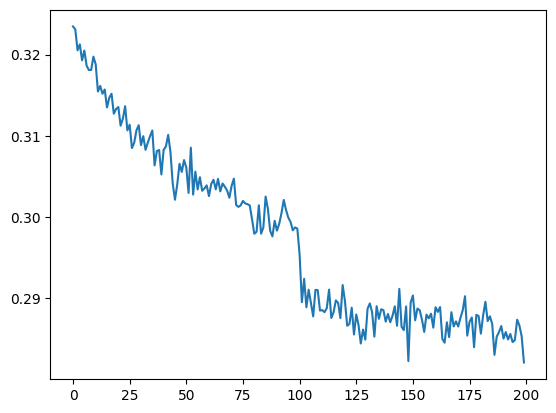

In [91]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [ ]:
# set layers out of training mode(especially important for batchnorm)
for layer in model.layers:
	layer.training = False

In [92]:
@torch.no_grad() # decorator disables gradient tracking
def split_loss(split):
	x, y = {
		'train': (Xtr, Ytr), 
		'val': (Xdev, Ydev),
		'test': (Xtest, Ytest)
	}[split]
	# do forward pass on all training data
	logits = model(x)
	loss = F.cross_entropy(logits, y)
	print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9108775854110718
val 2.019292116165161


**Performance log**
- original (3 char context + 200 hidden neurons, 12k params): train 2.058, val 2.105
- context: 3 -> 8 (22k params): train 1.918, val 2.027
- flat -> hierarchical: (22k params): train 1.94, val 2.029
- fix batchnorm1d bug: train 1.912, val, 2.022
- trained an extra ~20k steps(? i think): train 1.9108, val 2.019

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
		
		out = []
		context = [0] * block_size # initialize with all ...
		while True:
			# forward pass the neural net
			logits = model(torch.tensor([context]))
			probs = F.softmax(logits, dim=1)
		 
			# sample from the distribution
			ix = torch.multinomial(probs, num_samples=1, generator=g).item()
			# shift the context window and track the samples
			context = context[1:] + [ix]
			out.append(ix)
			# if we sample the special '.' token, break
			if ix == 0:
				break
		
		print(''.join(itos[i] for i in out)) # decode and print the generated word

erquagmyazzhzevvndhfyaloqetvrsjejdrlrg.
azcjedgeliizempqppalekeixvqnwxarveptzcmhvqrpcn.
szdbvrgxhgmjest.
jcjrwjljqqxntpucfkubzkgvdtrxyqqufmehg.
kmejqvskkydmzhjl.
cakyybsufpzbjglvjurenjcrtvwsvevoecmpfhdxrfqnxoeobhggptixjsfcueywhkhmreolbiilqiif.
evpkxwvlla.
odtabfsztjndgoizvsblitbfkxvbsfivpu.
meewrkepxcmvyhxavttudkjgczekhgcgtipvtudt.
iwbdnihzvorlq.
cjakepxugniagcrpcpfmiipzjgvonxet.
jydnblksqzporygnogzvmwosfzybsyknvmjcxtkncjbmu.
jtew.
amw.
copmrlxkkdcqbcep.
ccdfivsnicimhteymosagouwzlrurdckappomtcokwxtnbnzkdphfam.
xconfffuncxzhosynsj.
ascnpc.
cilwtanczhrdtebimm.
ynw.
